In [1]:
import apogee.tools.read as apread
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import apogee.spec.window as wn
from apogee.spec import lsf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import apogee.spec

In [2]:
data = apread.rcsample()

In [3]:
def get_spectra_asp(data,ext = 1,header=False):
    """
    Returns spectra and header information for each object specified in data
    
    data:    labels for a subset of the APOGEE survey
    """
    specs = []
    hdrs = {}
    for i in range(len(data)):
        spec = apread.aspcapStar(data['LOCATION_ID'][i],data['APOGEE_ID'][i],ext = ext, header = header, aspcapWavegrid=True)
        if header:
            spec,hdr = spec
            hdrs[i] = hdr
        specs.append(spec)
    if header:
        return np.array(specs),hdrs
    elif not header:
        return np.array(specs)

def get_spectra_ap(data,ext = 1, header = False):
    specs = []
    hdrs = {}
    for i in range(len(data)):
        spec = apread.apStar(data['LOCATION_ID'][i],data['APOGEE_ID'][i],ext = ext, header = header, aspcapWavegrid=True)
        if header:
            spec,hdr = spec
            hdrs[i] = hdr
        specs.append(spec)
    if header:
        return np.array(specs),hdrs
    elif not header:
        return np.array(specs)

def makematrix_indep(x,order):
    if isinstance(x,tuple):
        nindeps = len(x)
        X = np.empty((len(x[0]),order*nindeps+1))
        X[:,0] = x[0]**0
        i = 1
        while i < order*nindeps+1:
            for o in range(1,order+1):
                for n in range(nindeps):
                    X[:,i] = x[n]**o
                    i+=1
    elif isinstance(x,(list,np.ndarray)):
        X = np.empty((len(x),order+1))
        for o in range(order+1):
            X[:,o] = x**o
    X = np.matrix(X)
    return X

def regfit(x,y,err = 0,order = 1):
    """
    Fits a (nD-)polynomial of specified order with independent values given in x,
    given dependent values in y.
    
    x:       array of independent variable 
            (may be tuple containing arrays of multiple variables)   
    y:       array of dependent variable (must have same shape as array in x)
    order:   order of polynomial to fit (kwarg, default = 1)
    
    Returns the polynomial coefficents ascending from 0th order. In the case of
    multiple independent variables, returns coefficients at each polynomial order
    in order of the variables listed in x.
    """
    X = makematrix_indep(x,order)
    if isinstance(err,(float,int)):
        return np.array(np.linalg.inv(X.T*X)*X.T*np.matrix(y).T)
    elif isinstance(err,(list,np.ndarray)):
        cov = np.diag(err**2)
        icov = np.linalg.inv(cov)
        return np.array(np.linalg.inv(X.T*icov*X)*(X.T*icov*np.matrix(y).T))

def regerr(x,y,xerr,yerr,order=1):
    X = makematrix(x,order)
    Xerr = makematrix(xerr,order)
    

def poly_indep(p,x,param = None,order = 1):
    """
    For a given set of polynomial coefficients ascending from
    0th order, and a independent variables, returns polynomial.
    """
    if isinstance(x,tuple):
        nindeps = len(x)
        order = (len(p)-1)/nindeps
        y = np.zeros(x[0].shape)
        y += p[0]*x[0]**0
        i = 1
        while i < order*nindeps+1:
            for o in range(1,order+1):
                if param == None:
                    for n in range(nindeps):
                        y+=p[i]*x[n]**o
                        i+=1
                elif param != None:
                    n = param
                    y+=p[i]*x[n]**o
                    i+=1
    elif isinstance(x,(list,np.ndarray)):
        order = len(p)-1
        y = np.zeros(x.shape)
        o = 0
        while o <= order:
            y += p[o]*x**o
            o += 1
    return y

def stderr(yreal,yfit,p):
    return np.sqrt(np.sum((yreal-yfit)**2)/(len(yreal)-len(p)))

In [19]:
# Basic function testing
x = np.arange(2,5,0.01)
c = np.log(np.copy(x))
y = np.copy(x)**3+c**2+9
ptest = regfit((x,c),y,order = 3)

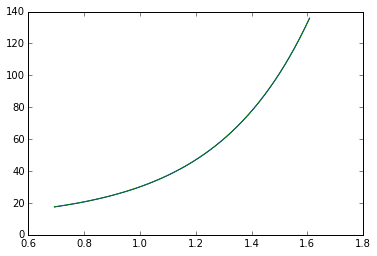

In [20]:
# Basic function testing
plt.plot(c,y)
plt.plot(c,poly(ptest,(x,c),order = 3))

In [4]:
def slice_data(data,sliceinfo):
    label, lower, upper = sliceinfo
    indx = (data[label]>lower) & (data[label]<upper)
    return data[indx]

def pixmask_find(maskdata,pix):
    mask = []
    for i in range(len(maskdata)):
        if len(maskdata[i].shape) > 1:
            if any(maskdata[i][:,pix]) != 0:
                mask.append(1)
            elif all(maskdata[i][:,pix]) == 0:
                mask.append(0)
        elif len(maskdata[i].shape) == 1:
            if maskdata[i][pix] != 0:
                mask.append(1)
            elif maskdata[i][pix] == 0:
                mask.append(0)   
    indx = np.where(np.array(mask) != 1)
    return indx
sdata = slice_data(data,['FE_H',-0.5,-0.4])
maskdata = get_spectra_ap(sdata,ext = 3, header = False)
specs,hdrs = get_spectra_asp(sdata,header = True)
errs = get_spectra_asp(sdata,ext = 2, header = False)

In [5]:
O = 2
ps = []
ress = []
discard = []
for pix in range(len(specs[0])):
    print pix,' of ',len(specs[0])
    mask = pixmask_find(maskdata,pix)
    mdata = sdata[mask]
    mspecs = specs[mask]
    merrs = errs[mask]
    discard.append(len(sdata)-len(mask[0]))
    try:
        p = regfit((mdata['TEFF'],mdata['LOGG'],mdata['METALS']),mspecs[:,pix],err = merrs[:,pix],order = O)
        ps.append(p)
        res = mspecs[:,pix] - poly_indep(p,(mdata['TEFF'],mdata['LOGG'],mdata['METALS']),order = O)
        ress.append(res)
    except LinAlgError:
        continue

0  of  7214
1  of  7214
2  of  7214
3  of  7214
4  of  7214
5  of  7214
6  of  7214
7  of  7214
8  of  7214
9  of  7214
10  of  7214
11  of  7214
12  of  7214
13  of  7214
14  of  7214
15  of  7214
16  of  7214
17  of  7214
18  of  7214
19  of  7214
20  of  7214
21  of  7214
22  of  7214
23  of  7214
24  of  7214
25  of  7214
26  of  7214
27  of  7214
28  of  7214
29  of  7214
30  of  7214
31  of  7214
32  of  7214
33  of  7214
34  of  7214
35  of  7214
36  of  7214
37  of  7214
38  of  7214
39  of  7214
40  of  7214
41  of  7214
42  of  7214
43  of  7214
44  of  7214
45  of  7214
46  of  7214
47  of  7214
48  of  7214
49  of  7214
50  of  7214
51  of  7214
52  of  7214
53  of  7214
54  of  7214
55  of  7214
56  of  7214
57  of  7214
58  of  7214
59  of  7214
60  of  7214
61  of  7214
62  of  7214
63  of  7214
64  of  7214
65  of  7214
66  of  7214
67  of  7214
68  of  7214
69  of  7214
70  of  7214
71  of  7214
72  of  7214
73  of  7214
74  of  7214
75  of  7214
76  of  7214
77  of  7

In [ ]:
wSi = wn.read('Si',dr = 12,apStarWavegrid=False)

def normweights(weights):
    return weights/np.sum(weights)
    
def genresidual(weights,residuals):
    return np.matrix(weights).T*np.matrix(residuals)
nwSi = normweights(wSi)
resids = genresidual(nwSi,ress)

In [8]:
pix = 6296
Teff = np.arange(min(mdata['TEFF']),max(mdata['TEFF']))
logg = np.arange(min(mdata['LOGG']),max(mdata['LOGG']),((max(mdata['LOGG']-min(mdata['LOGG'])))/len(Teff)))
metals = np.arange(min(mdata['METALS']),max(mdata['METALS']),((max(mdata['METALS']-min(mdata['METALS'])))/len(Teff)))
pl = np.where(errs[:,pix] < 0.1)
rpl = np.where(errs[:,pix] > 0.1)

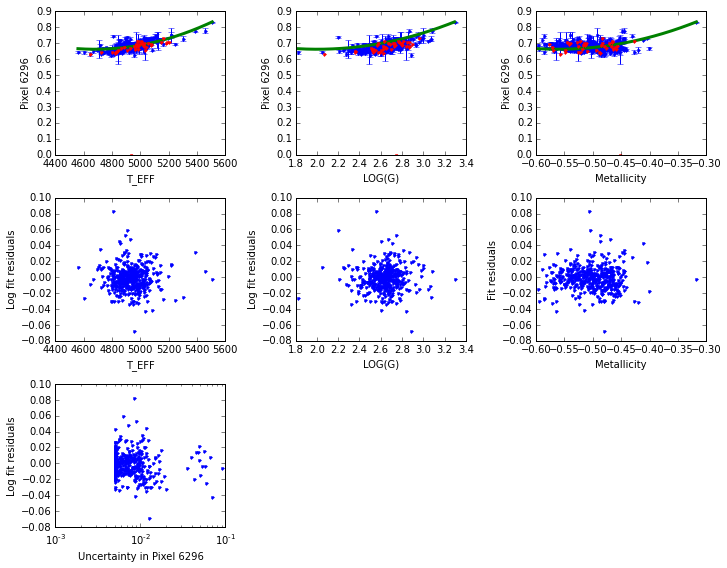

In [9]:
res = specs[:,pix] - poly_indep(p,(mdata['TEFF'],mdata['LOGG'],mdata['METALS']),order = O)
plt.figure(figsize = (10,8))
plt.subplot2grid((3,3),(0,0))
plt.errorbar(mdata['TEFF'][pl],specs[:,pix][pl],yerr = errs[:,pix][pl],fmt='.')
plt.plot(Teff,poly_indep(p,(Teff,logg,metals),order = O),linewidth = 3)
plt.plot(mdata['TEFF'][rpl],specs[:,pix][rpl],'.')
plt.xlabel('T_EFF')
plt.ylabel('Pixel {0}'.format(pix))
plt.subplot2grid((3,3),(1,0))
plt.plot(mdata['TEFF'][pl],res[pl],'.')
plt.xlabel('T_EFF')
plt.ylabel('Log fit residuals')
plt.subplot2grid((3,3),(2,0))
plt.semilogx(errs[:,pix][pl],res[pl],'.')
plt.xlabel('Uncertainty in Pixel {0}'.format(pix))
plt.ylabel('Log fit residuals')
plt.subplot2grid((3,3),(0,1))
plt.errorbar(mdata['LOGG'][pl],specs[:,pix][pl],yerr = errs[:,pix][pl],fmt='.')
plt.plot(logg,poly_indep(p,(Teff,logg,metals),order = O),linewidth = 3)
plt.plot(mdata['LOGG'][rpl],specs[:,pix][rpl],'.')
plt.xlabel('LOG(G)')
plt.ylabel('Pixel {0}'.format(pix))
plt.subplot2grid((3,3),(1,1))
plt.plot(mdata['LOGG'][pl],res[pl],'.')
plt.xlabel('LOG(G)')
plt.ylabel('Log fit residuals')
plt.tight_layout()
plt.subplot2grid((3,3),(0,2))
plt.errorbar(mdata['METALS'][pl],specs[:,pix][pl],yerr = errs[:,pix][pl],fmt='.')
plt.plot(metals,poly_indep(p,(Teff,logg,metals),order = O),linewidth = 3)
plt.plot(mdata['METALS'][rpl],specs[:,pix][rpl],'.')
plt.xlabel('Metallicity')
plt.ylabel('Pixel {0}'.format(pix))
plt.subplot2grid((3,3),(1,2))
plt.plot(mdata['METALS'][pl],res[pl],'.')
plt.xlabel('Metallicity')
plt.ylabel('Fit residuals')

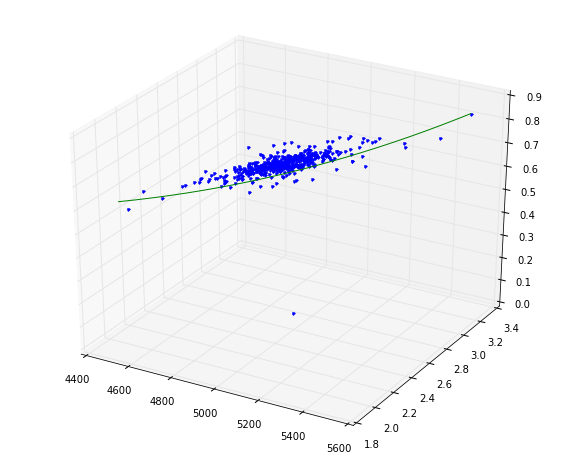

In [8]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(mdata['TEFF'],mdata['LOGG'],specs[:,6296],'.')
ax.plot(Teff,logg,poly_indep(p,(Teff,logg,metals)))

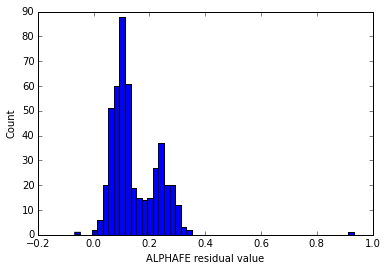

In [9]:
def histplot(res,mdata,abun_key,bins = 50,findgood = False):
    if findgood:
        good = np.where(mdata[abun_key] != -9999)
        newres = res[good]
        abun = mdata[abun_key][good]
    elif not findgood:
        newres = np.copy(res)
        abun = np.copy(mdata[abun_key])
    plt.hist(abun-newres,bins=bins)
    plt.xlabel('{0} residual value'.format(abun_key))
    plt.ylabel('Count')

bins = 50
res = specs[:,pix] - poly_indep(p,(mdata['TEFF'],mdata['LOGG'],mdata['METALS']),order = O)
histplot(res,mdata,'ALPHAFE')

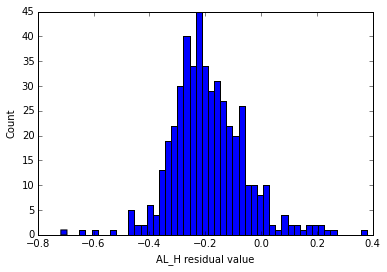

In [10]:
histplot(res,mdata,'AL_H',findgood=True)

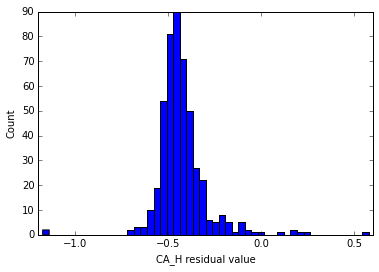

In [11]:
histplot(res,mdata,'CA_H',findgood=True)

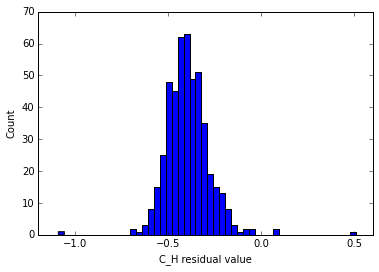

In [12]:
histplot(res,mdata,'C_H',findgood = True)

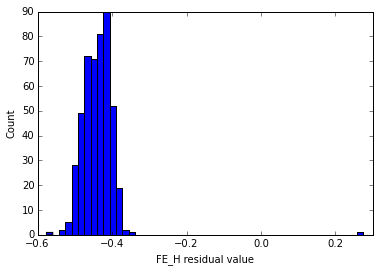

In [13]:
histplot(res,mdata,'FE_H',findgood=True)

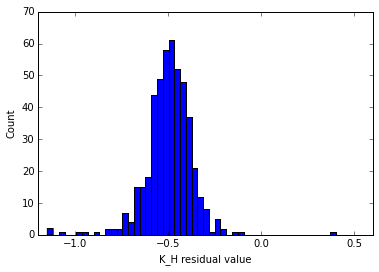

In [14]:
histplot(res,mdata,'K_H',findgood=True)

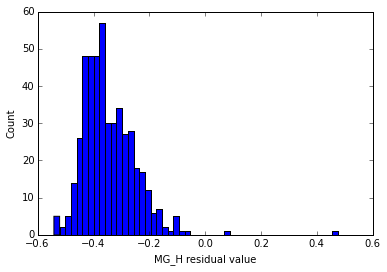

In [15]:
histplot(res,mdata,'MG_H',findgood=True)

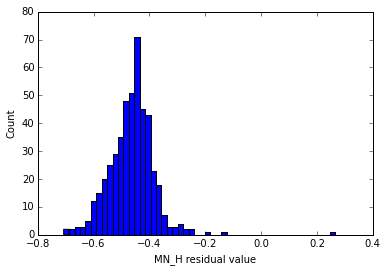

In [16]:
histplot(res,mdata,'MN_H',findgood=True)

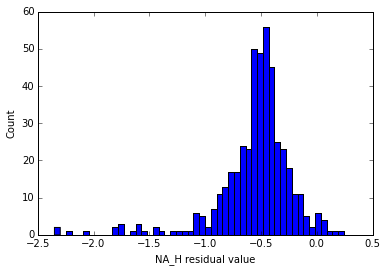

In [17]:
histplot(res,mdata,'NA_H',findgood=True)

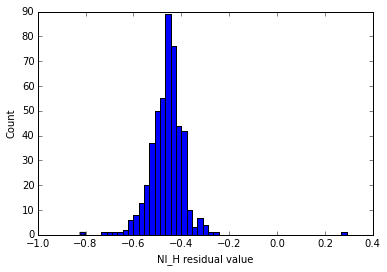

In [18]:
histplot(res,mdata,'NI_H',findgood=True)

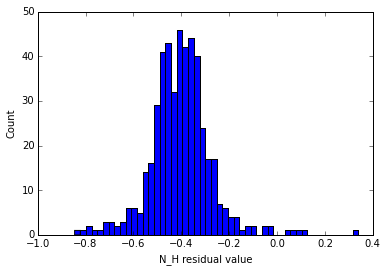

In [19]:
histplot(res,mdata,'N_H',findgood=True)

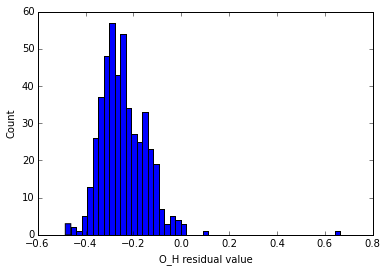

In [20]:
histplot(res,mdata,'O_H',findgood=True)

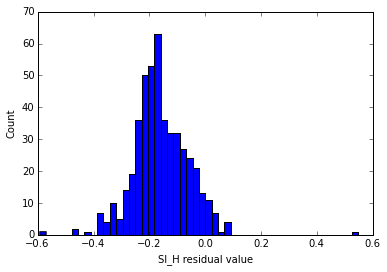

In [21]:
histplot(res,mdata,'SI_H',findgood=True)

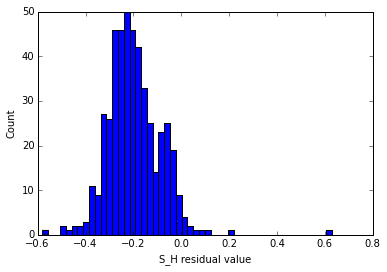

In [22]:
histplot(res,mdata,'S_H',findgood=True)

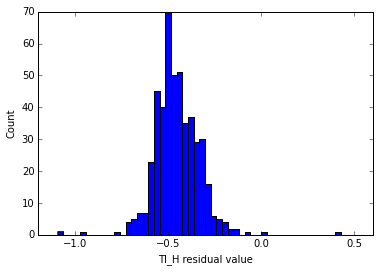

In [23]:
histplot(res,mdata,'TI_H',findgood=True)

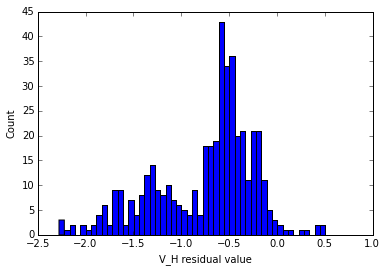

In [24]:
histplot(res,mdata,'V_H',findgood=True)

In [27]:
plt.ion()
def histplot2d(x,y,nbins = 50 ,maskval = 0,saveloc = '',labels=[]):
	"""
	Creates a 2D histogram from data given by numpy's histogram

	x,y:		two 2D arrays to correlate
	nbins:		number of bins
	maskval:	value that indicates masked areas
				(kwarg, default = 0)
	saveloc:	place to save histogram plot - if unspecified, do not
				save plot (kwarg, default = '')
	labels:		labels for histogram plot, with the following format
				[title,xlabel,ylabel,zlabel] - if unspecified, do 
				not label plot (kwarg, default = [])
	slope:		slope of correlation fit line (kwarg, default = 1)
	slopeerr:	uncertainties in slope of fit line (kwarg, default = 0)

	Returns the edges of the histogram bins and the 2D histogram

	"""
	# Remove NANs and masked values
	good = np.where((isnan(x) == False) & (isnan(y) == False) & (x != maskval) & (y != maskval))
	x = x[good]
	y = y[good]
	uplim = np.max(x)+5
	dolim = np.min(x)-5
	# Create histogram
	H,xedges,yedges = np.histogram2d(x,y,bins=nbins)
	# Reorient appropriately
	H = np.rot90(H)
	H = np.flipud(H)
	# Mask zero value bins
	Hmasked = ma.masked_where(H==0,H)
	# Begin creating figure
	plt.figure(figsize=(12,10))
	# Make histogram pixels with logscale
	plt.pcolormesh(xedges,yedges,Hmasked,
	               norm = LogNorm(vmin = Hmasked.min(),
	                              vmax = Hmasked.max()),
		       	   cmap = plt.get_cmap('Spectral_r'))
	# Set plot limits
	plt.xlim(dolim+5,uplim-5)
	plt.ylim(np.min(y),np.max(y))
	# Add colourbar
	cbar = plt.colorbar()
	# Add labels
	if labels != []:
	    title,xlabel,ylabel,zlabel = labels
	    plt.xlabel(xlabel)
	    plt.ylabel(ylabel)
	    plt.title(title)
	    cbar.ax.set_ylabel(zlabel)
	# Save plot
	if saveloc != '':
		plt.savefig(saveloc)
        plt.close()
	# Return histogram
	return xedges,yedges,Hmasked
#good = np.where(data['FE_H'] != -9999)
a = histplot2d(data['FE_H'],data['ALPHAFE'],nbins = 50 ,maskval = -9999,saveloc = '/home/price-jones/Code/APOGEE/rcapogee-plots/sequences.png',labels=['Sequences','[Fe/H]','[Alpha/Fe]','Number of RC stars'])

In [32]:
a = wn.read('Si',dr = 12,apStarWavegrid=False)
len(a)

7214

In [14]:
# Lists of (air) line locations:

FEI_lines = [15194.492,15207.526,15395.718,15490.339,15648.510,15964.867,16040.657,16153.247,16165.032]
MGI_lines = [15740.716,15748.9,15765.8,15879.5,15886.2,15889.485,15954.477]
ALI_lines = [16718.957,16763.359]
SII_lines = [15361.161,15376.831,15833.602,15960.063,16060.009,16094.787,16215.670,16680.770,16828.159]
KI_lines = [15163.067,15168.376]
CAI_lines = [16136.823,16150.763,16155.236,16157.364]
TII_lines = [15543.756,15602.842,15698.979,15715.573,16635.161]
VI_lines = [15924.]
CRI_lines = [15680.063,15860.214]
MNI_lines = [15159.,15217.,15262.]
COI_lines = [16757.7]
NII_lines = [15605.680,15632.654,16584.439,16589.295,16673.711,16815.471,16818.760]
CUI_lines = [16005.7]
NAI_lines = [16373.86,16388.85]

In [15]:
Al_pix = lsf.wave2pix(ALI_lines)

TypeError: wave2pix() takes at least 2 arguments (1 given)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   2.,   1.,   4.,  12.,   8.,  16.,  22.,  36.,
         46.,  54.,  53.,  61.,  55.,  37.,  20.,  12.,  11.,   6.,   8.,
          2.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.]),
 array([-0.1  , -0.096, -0.092, -0.088, -0.084, -0.08 , -0.076, -0.072,
        -0.068, -0.064, -0.06 , -0.056, -0.052, -0.048, -0.044, -0.04 ,
        -0.036, -0.032, -0.028, -0.024, -0.02 , -0.016, -0.012, -0.008,
        -0.004,  0.   ,  0.004,  0.008,  0.012,  0.016,  0.02 ,  0.024,
         0.028,  0.032,  0.036,  0.04 ,  0.044,  0.048,  0.052,  0.056,
         0.06 ,  0.064,  0.068,  0.072,  0.076,  0.08 ,  0.084,  0.088,
         0.092,  0.096,  0.1  ]),
 <a list of 50 Patch objects>)

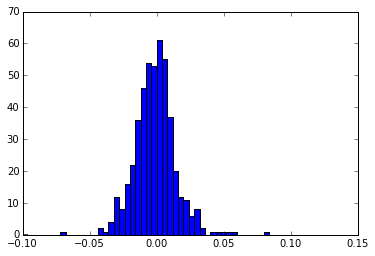

In [12]:
plt.hist(res,bins = 50,range=(-0.1,0.1))

(300, 2048)